# Imports

In [1]:
import warnings
import numpy as np
import ipywidgets as widgets

from matplotlib import pyplot as plt
from importlib import reload
from common.baseclasses import AWA

from NearFieldOptics import Materials as M
import EigenProbe as EP
S=EP.S

from ipywidgets import interact, interactive, fixed, interact_manual

warnings.filterwarnings('ignore')


Bad key text.latex.unicode in file /Users/alexandersmcleod/.matplotlib/matplotlibrc, line 167 ('text.latex.unicode : True # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.0/matplotlibrc.template
or from the matplotlib source distribution


<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "Bi2Se3_epsilon.pickle"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "PMMA_epsilon.pickle"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "sio2_300nm_extracted_epsilon_cone_A=2a.pickle"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "TaS2_eps_230K.csv"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "TaS2_eps_30K.csv"...


/Users/alexandersmcleod/tools/python/common/baseclasses.py:473: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  try: result=ndarray_operator(self,*args,**kwargs)
/Users/alexandersmcleod/tools/python/common/baseclasses.py:482: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  for axis_grid in axis_grids]


<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "Erik_BSTS_epsilon.pickle"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "VO2_295K.csv"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "VO2_360K.csv"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "Stewart_V2O3film_insulating.csv"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "Stewart_V2O3film_metallic.csv"...


# Set up the problem

## Define graphene

Generating eigenpairs on x,y=[-200.0:+200.0:300],[-200.0:+200.0:300]
	Time elapsed: 2.1089560985565186
Generating eigenpairs on x,y=[-200.0:+200.0:300],[-200.0:+200.0:300]
	Time elapsed: 1.6059308052062988


Text(0.5, 1.0, 'Eigenfunction 10 of Graphene sheet')

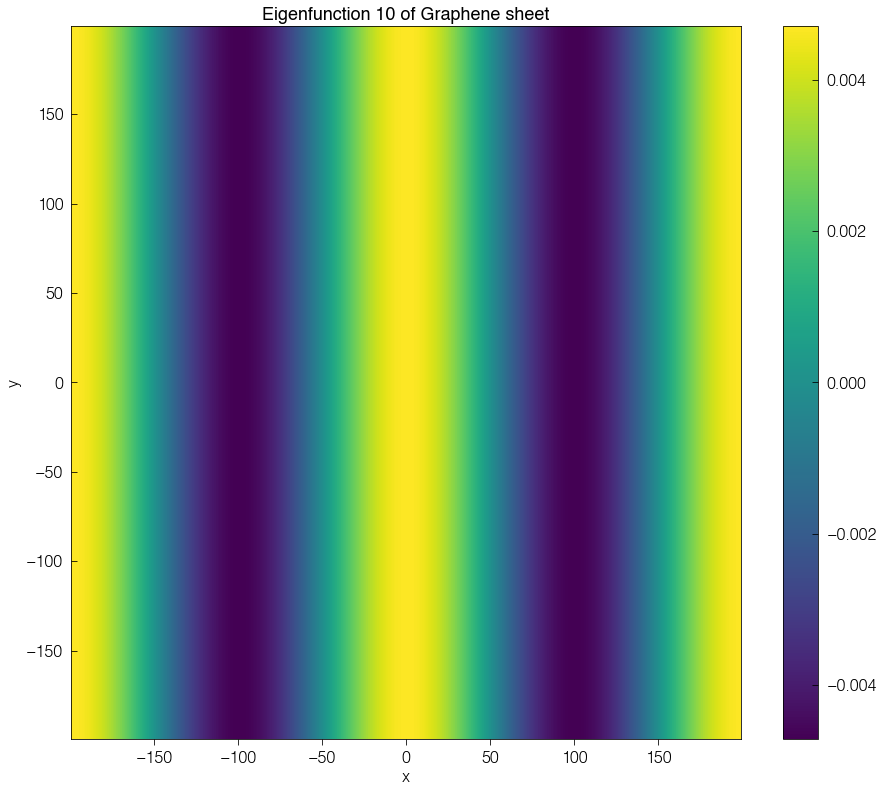

In [2]:
#--- Build rectangular laplacian with edge for graphene (particle-in-box planewaves)
N=300
Lx,Ly=400,400
Nq=1000

Rx=Lx*.8
Dx=(Lx-Rx)/2
Graphene=S.SpectralLaplacian_ribbon(Lx=Lx,Nx=N,Ly=Ly,Nqmax=Nq,Rx=Rx,x0=Dx)
#Use this for a homogeneous graphene sheet, without any edges
Graphene=S.SpectralLaplacian_uniform(Lx=Lx,Nx=N,Ly=Ly,Nqmax=Nq)
X,Y=Graphene.XY
x,y=Graphene.xy

dx=np.diff(x)[0]

eigindex=10
plt.figure(figsize=(15,12))
Graphene.eigenfunctions[eigindex].plot()
plt.title('Eigenfunction %i of Graphene sheet'%eigindex)

## Define inhomogeneous defect

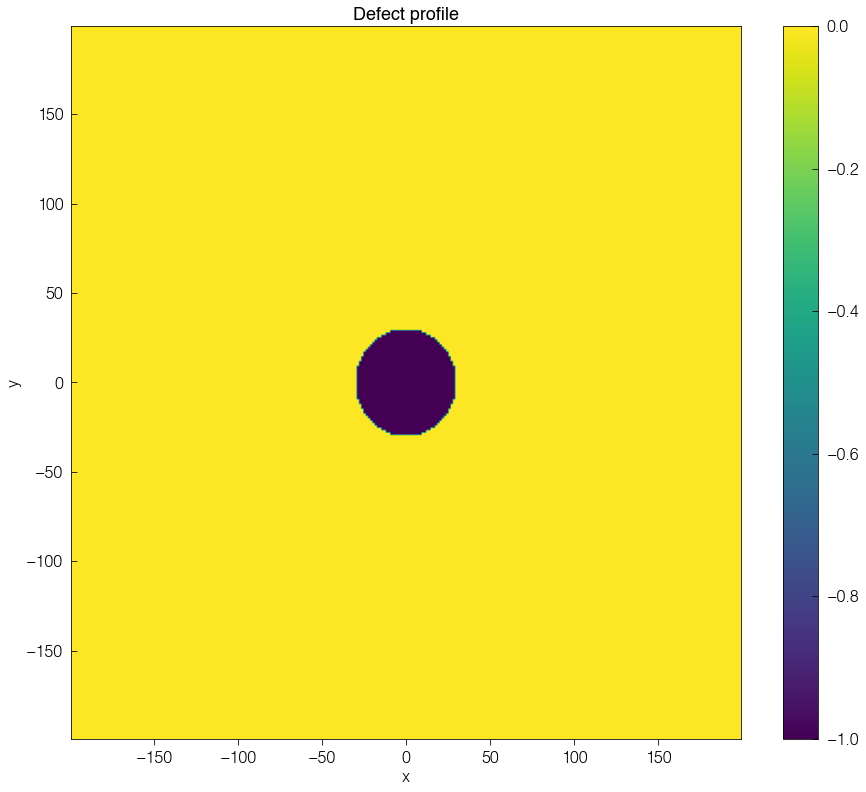

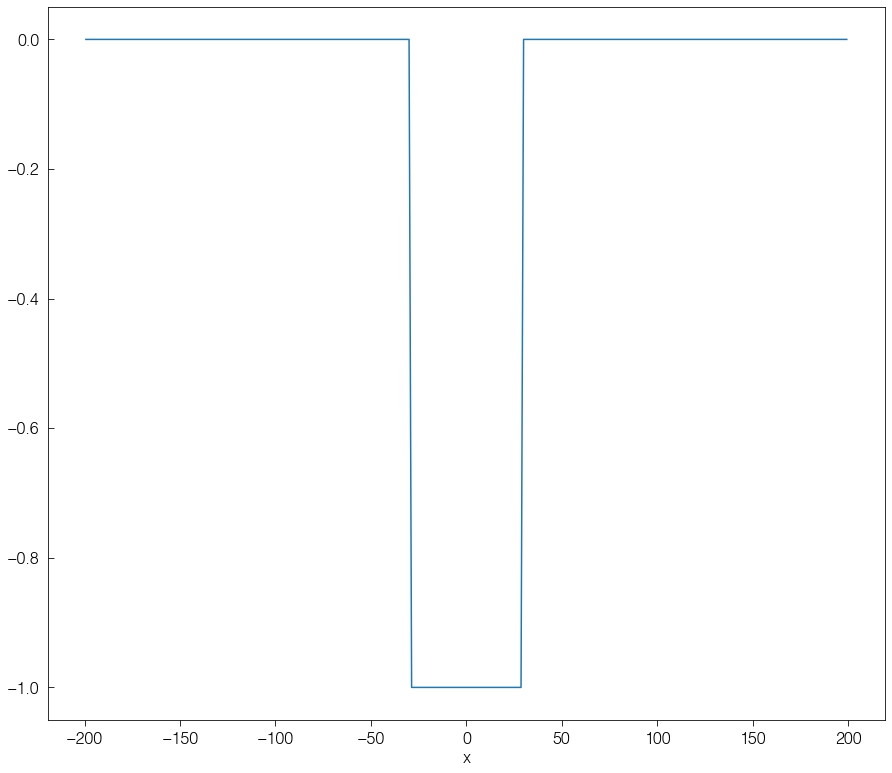

In [3]:
#--- Build inhomogeneous conductivity
x_defect=0
defect_radius=30
defect_profile=((X-x_defect)**2+Y**2 < defect_radius**2).astype(float) #a dot

Defect=S.GridLaplacian_aperiodic(dx,sigma=defect_profile)
#Defect=Defect.as_SpectralOperator(Graphene) #Project into graphene basis, doing this first somehow saves memory in construction of Green's
sigmaDefect=S.utils.Constant(-1)

plt.figure(figsize=(15,12))
AWA(sigmaDefect*defect_profile,adopt_axes_from=Graphene.AWA).real.plot()
plt.title('Defect profile')

plt.figure(figsize=(15,12))
AWA(sigmaDefect*defect_profile,adopt_axes_from=Graphene.AWA).cslice[:,0].real.plot()


## Define substrate

Generating eigenpairs on x,y=[-200.0:+200.0:300],[-200.0:+200.0:300]
	Time elapsed: 1.4685239791870117
hBN polariton wavelength (simulation units): 40.61384660534476
hBN substrate average reflectivity: beta= 0


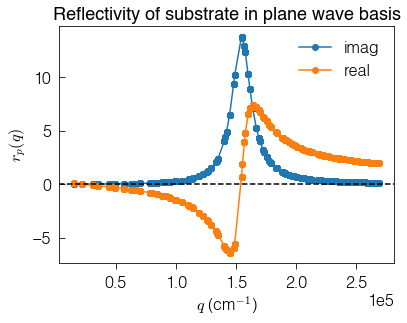

In [4]:
freq=1480
layers=M.LayeredMediaTM((M.BN_Caldwell,40e-7),exit=M.SiO2_300nm)

length_unit=10e-7 #Size of a pixel in cm --> 10e-7 = 10 nm
Substrate=EP.SubstrateFromLayers(layers,length_unit,freq=freq,\
                                 Lx=Lx,Ly=Ly,Nx=N,Nqmax=Nq)

plt.figure()
Substrate.rp.imag.plot(marker='o',label='imag')
Substrate.rp.real.plot(marker='o',label='real')
plt.ylabel('$r_p(q)$')

qs=Substrate.rp.axes[0]
print('hBN polariton wavelength (simulation units):',\
       2*np.pi/qs[np.argmax(Substrate.rp.imag)]/length_unit)

#This value will allow us to crudely "guess" what the screened plasmon wavelength will be
beta=0
plt.axhline(beta,color='k',ls='--')

print('hBN substrate average reflectivity: beta=',beta)
plt.title('Reflectivity of substrate in plane wave basis')
plt.legend()

In [5]:
# Use this for just a dielectric substrate
#beta=.5
#Substrate=EP.SubstrateDielectric(beta=beta,Lx=Lx,Ly=Ly,Nx=N,Nqmax=Nq)

## Define PML

In [6]:
PML=EP.DefaultPML(size=(Lx,Ly),Nx=N,Nfwhm=8,Nwidth=30,k=2,Nbuf=1)
PML_domain=PML.get_PML_domain()

In [7]:
Q=20 #Quality factor of graphene plasmons
PS=EP.Photonic2DSystem(Substrate,(Graphene,Defect),
                       lambdap=20,sigmas2D=(1-1j/Q,sigmaDefect),
                       PML=PML,PML_amplitude=10,\
                       basis=None,Nbasis=Nq)

Constructing augmented basis with 2D materials...
Finding augmented basis by QR decomposition...
	Removed 928 redundant vectors.
	Time elapsed: 32.875577211380005
Building Laplacian operator in augmented basis...
Building 928x928 inner product matrix...
	Time elapsed: 0.8867061138153076
Building 928x928 inner product matrix...
	Time elapsed: 0.9061720371246338
Diagonalizing new Hermitian operator of size (928, 928)...
	Time elapsed: 3.1244661808013916
	Time elapsed: 8.3367440700531
Filtered 0 eigenpairs.
Filtered 0 eigenpairs.
Size of composite laplacian: 929
Projecting operator 1 onto basis...
Building 929x928 inner product matrix...
	Time elapsed: 0.9137730598449707
Projecting operator 2 onto basis...
Computing aperiodic Laplacian...
	Time elapsed: 7.042396306991577
Building 929x929 inner product matrix...
	Time elapsed: 3.4869837760925293
Projecting operator 3 onto basis...
Building 929x929 inner product matrix...
	Time elapsed: 0.9244117736816406
Projecting operator 4 onto basis...

## Combine all the elements into a `Photonic2DSystem`

# Simulate response

## Configure excitation functions

In [8]:
a=2 #This is a tip radius of (a px)*(10 nm/px)
x,y=PS.xy
X,Y=PS.XY

### Example dipole excitations

In [9]:
#--- This is just a dipole, emulating the field from a tip

# This can probe the sample at single locations, linescans, or raster scans
DipoleTip=EP.DipoleProbe(x,y,tipsize=a)   

### Realistic tip excitation (Experimental)

In [10]:
#--- This is a more realistic excitation from the tip
# `tipsize=2` means 2*10 nm = 20 nm tip
LoadedTip=EP.EigenProbe(xs=x,ys=y,fname='hyperboloid_load_freq=1000 (best).pickle',\
                   tipsize=a,periodic=True,ztip=0,window=np.hamming)

def RealTip(x0,y0,eigenoscillation=0,**kwargs):
    return LoadedTip(x0,y0)[eigenoscillation]

Loading probe from file "/Users/alexandersmcleod/tools/python/EigenProbe/probe_library/hyperboloid_load_freq=1000 (best).pickle"...
Building interpolators...
	Time elapsed: 0.0040018558502197266


### Bonus tools for delivering excitation

In [11]:
#--- A spectroscopy function for sweeping a parameter and registering sample response
def spectroscopy(PS,param,vals,param_name=None,\
                 excitation=DipoleTip,x0=10,y0=0,\
                 verbose=True,**kwargs):
    
    if not param_name: param_name='parameter'
    
    if verbose: print('Staging excitation into basis...')
    
    #--- Make excitation
    X,Y=PS.XY
    exc=S.normalize(excitation(x0,y0,**kwargs))
    vE=PS.vectors_from(exc)

    #--- Define how we will collect the response: project back into excitation
    #collect_in=(~PML_domain.astype(bool)) #collect in region outside PML
    #vC=PS.vectors_from(exc*collect_in)
    vC=vE #keep it simple for now

    spectrum=[]
    for val in vals:
        if verbose: print('Working on `%s=%1.2f`'%(param_name,val))
        param.set_value(val)
        R=PS.matrix
        #--- Get response at each value of `param`
        spectrum.append(np.complex(vC.T @ R @ vE))
        
    return AWA(spectrum,axes=[vals],axis_names=[param_name]) 

## Look at real-space response to an excitation

working on screened plasmon wavelength=20
working on screened plasmon wavelength=40
working on screened plasmon wavelength=60


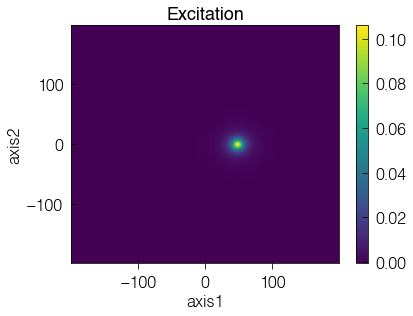

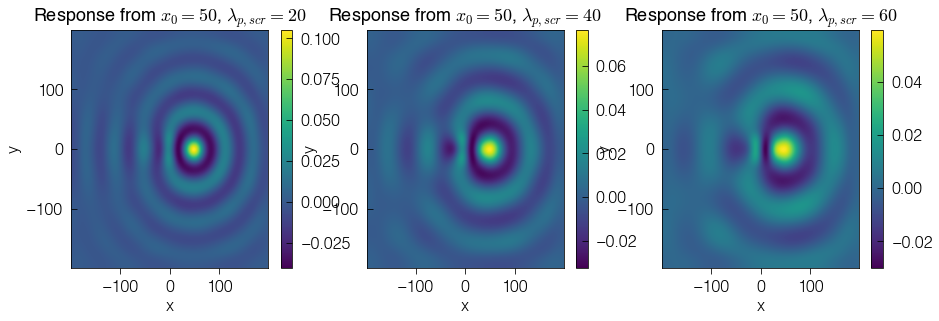

In [12]:
#--- Create an excitation
x0,y0=x_defect+50,0
exc=DipoleTip(x0,y0) #use dipole excitation

plt.figure()
exc.real.plot()
plt.title('Excitation')

Q=20
PS.set_Sigma2D(0,1-1j/Q)
PS.set_PML_amplitude(1)

#Solve inverse problem for a series of wavelengths
i=0
fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(15,4))
for wl_screened in [20,40,60]:
    print('working on screened plasmon wavelength=%s'%wl_screened)
    PS.set_LambdaP(wl_screened/(1-beta))
    resp=PS(exc)

    plt.sca(ax[i])
    i+=1
    np.imag(resp).plot()
    plt.title('Response from $x_0=%s$, $\lambda_{p,scr}=%i$'%(x0,wl_screened))

## Do a linescan at fixed plasmon wavelength

Projecting excitation vectors...
	Time elapsed: 1.147202730178833
Computing reflection matrix...
	Time elapsed: 0.577873945236206
Computing reflection coefficient...
	Time elapsed: 0.018126726150512695


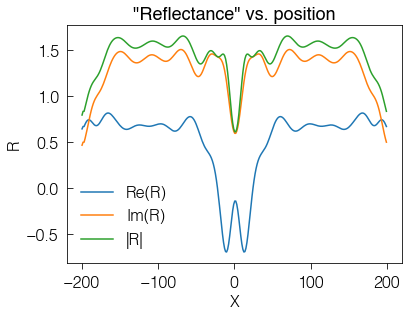

In [13]:
#--- Sample settings
Q=20
dsigma=0.01

PS.set_Sigma2D(0,1-1j/Q)
PS.set_Sigma2D(1,dsigma-1+1j/Q) #reduce conductivity at the defect down to `dsigma`

wl_screened=40
PS.set_LambdaP(wl_screened/(1-beta)) #plasmon wavelength
PS.set_PML_amplitude(1)

#--- Get response at each x0 position = linescan
x0s=PS.xy[0]
Rs = DipoleTip.probe(PS,X0=x0s,Y0=[0]*len(x0s))

#--- Plot real and imaginary reflectance signals
plt.figure()
plt.plot(x,np.real(Rs),label='Re(R)')
plt.plot(y,np.imag(Rs),label='Im(R)')
plt.plot(y,np.abs(Rs),label='|R|')
plt.xlabel('X')
plt.ylabel('R')
plt.title('"Reflectance" vs. position')
plt.legend()

## Do a raster-scan at fixed plasmon wavelength

In [14]:
stride=4 #Indicates how many pixels to skip in the 2-D raster scan
#Select a # for `chunks`, the calculation will be divided in that many segments
raster=DipoleTip.raster_probe(PS,stride=3,chunks=10)

Commencing a 100 x 100 raster-scan, in 10 chunks...
Projecting excitation vectors...
	Time elapsed: 2.3338429927825928
Computing reflection matrix...
	Time elapsed: 0.536268949508667
Computing reflection coefficient...
	Time elapsed: 0.07887911796569824
Finished chunk 1 of 10, 10.00% complete...
Projecting excitation vectors...
	Time elapsed: 2.3251566886901855
Computing reflection coefficient...
	Time elapsed: 0.07804083824157715
Finished chunk 2 of 10, 20.00% complete...
Projecting excitation vectors...
	Time elapsed: 2.2990357875823975
Computing reflection coefficient...
	Time elapsed: 0.06950974464416504
Finished chunk 3 of 10, 30.00% complete...
Projecting excitation vectors...
	Time elapsed: 2.2993428707122803
Computing reflection coefficient...
	Time elapsed: 0.07045292854309082
Finished chunk 4 of 10, 40.00% complete...
Projecting excitation vectors...
	Time elapsed: 2.3164820671081543
Computing reflection coefficient...
	Time elapsed: 0.06810998916625977
Finished chunk 5 of 10

Text(0.5, 1.0, 'Imaginary signal')

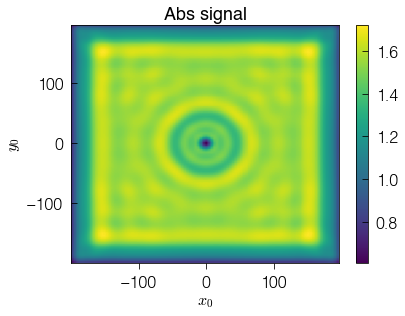

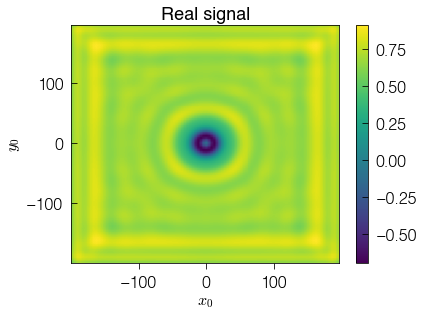

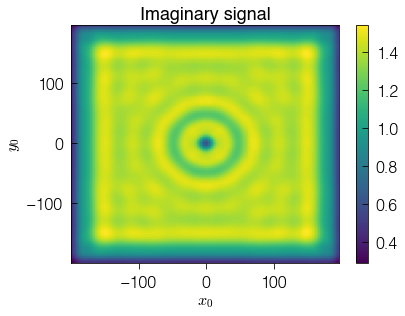

In [15]:
plt.figure()
np.abs(raster).plot()
plt.title('Abs signal')

plt.figure()
np.real(raster).plot()
plt.title('Real signal')

plt.figure()
np.imag(raster).plot()
plt.title('Imaginary signal')

## Linescans with dipole versus plasmon wavelength: Q=20

In [16]:
# Produce excitation and collection vectors for linescans
a=1
y0=0
x0s=PS.xy[0]
excs=[DipoleTip(x0,y0) for x0 in x] #use real tip excitation

vE=S.normalize(PS.vectors_from(excs))
vC=vE #PS.vectors_from([exc*(~PML_domain) for exc in excs]) #Exclude PML for detection

In [17]:
#--- Sample settings
Q=20
dsigma=0.01
PS.set_Sigma2D(0,1-1j/Q)
PS.set_Sigma2D(1,dsigma-1+1j/Q) #reduce conductivity at the defect down to `dsigma`
PS.set_PML_amplitude(1)

linescans1=[]
wls_screened=np.linspace(8,60,30)
for wl_screened in wls_screened:
    print('Working on screened wl=%s...'%wl_screened)
    
    #--- Get matrix representation of response operator
    PS.set_LambdaP(wl_screened/(1-beta)) #plasmon wavelength
    R = PS.matrix
    #--- Get response at each x0 position = linescan
    resps = np.diag(vC.T @ R @ vE)
    linescans1.append(resps)
    
linescans1=AWA(linescans1,axes=[wls_screened,x0s],\
              axis_names=[r'$\lambda_{p,scr}$','x'])

Working on screened wl=8.0...
Working on screened wl=9.793103448275861...
Working on screened wl=11.586206896551724...
Working on screened wl=13.379310344827587...
Working on screened wl=15.172413793103448...
Working on screened wl=16.96551724137931...
Working on screened wl=18.758620689655174...
Working on screened wl=20.551724137931036...
Working on screened wl=22.344827586206897...
Working on screened wl=24.137931034482758...
Working on screened wl=25.93103448275862...
Working on screened wl=27.724137931034484...
Working on screened wl=29.517241379310345...
Working on screened wl=31.310344827586206...
Working on screened wl=33.10344827586207...
Working on screened wl=34.896551724137936...
Working on screened wl=36.689655172413794...
Working on screened wl=38.48275862068965...
Working on screened wl=40.275862068965516...
Working on screened wl=42.06896551724138...
Working on screened wl=43.86206896551724...
Working on screened wl=45.6551724137931...
Working on screened wl=47.44827586

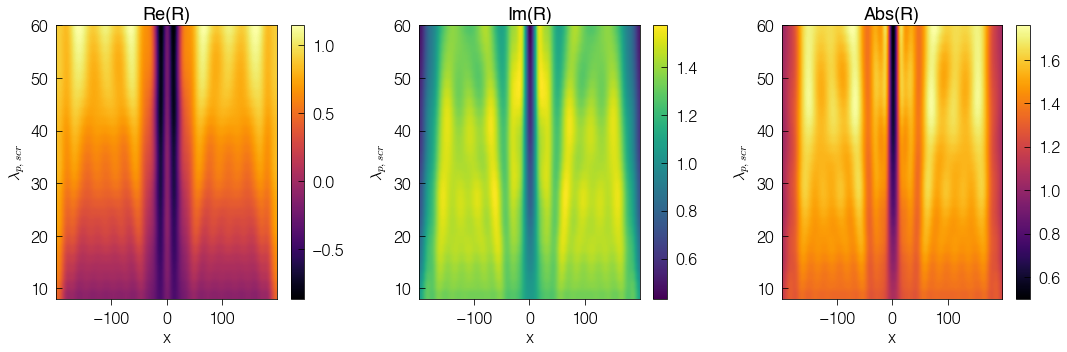

In [18]:
linescans=linescans1

fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(15,5))

plt.sca(ax[0])
linescans.real.T.plot(cmap='inferno')
plt.title('Re(R)')

plt.sca(ax[1])
linescans.imag.T.plot()
plt.title('Im(R)')

plt.sca(ax[2])
np.abs(linescans).T.plot(cmap='inferno')
plt.title('Abs(R)')
plt.tight_layout()

In [19]:
def plot_linescan(linescans,i,ylims1=(-1,1),ylims2=(0,1)):
    
    plt.figure(figsize=(16,4))
    linescan=linescans[i][~PML_domain.cslice[:,0]]
    wl_screened=linescans.axes[0][i]
    
    plt.subplot(131)
    linescan.real.plot(color='r')
    plt.title('Re(R): $\lambda_{p,scr}=%1.2f$'%wl_screened)
    plt.ylim(*ylims1)
    
    plt.subplot(132)
    linescan.imag.plot(color='b')
    plt.title('Im(R): $\lambda_{p,scr}=%1.2f$'%wl_screened)
    plt.ylim(*ylims2)
    
    plt.subplot(133)
    np.abs(linescan).plot(color='k')
    plt.title('Abs(R): $\lambda_{p,scr}=%1.2f$'%wl_screened)
    plt.ylim(*ylims2)
    return

linescans=linescans1
slider=widgets.IntSlider(min=0, max=len(linescans)-1, step=1, value=26,\
                         continuous_update=False)
plotter=lambda i: plot_linescan(linescans,i,(-.5,1),(-.2,1.5))
l=interact(plotter, i=slider);
l

interactive(children=(IntSlider(value=26, continuous_update=False, description='i', max=29), Output()), _dom_c…

<function __main__.<lambda>(i)>